Python for Data Analysis, GMC, Vilnius University, 2025

# HW4: Training a succesfull machine learning (ML) model

- **Tasks in this homework are built around a single data file** which should be downloaded in the Notebook as asked in the cell after the imports.
- Packages allowed to be imported (but not necessarily needed): `scikit-learn`, `numpy`, `pandas`, `matplotlib`, `seaborn`, `tqdm`, `itertools`, `math`, `string`. Do not import any other packages.
- **You will need to upload your solutions into your Github repository** dedicated for the Python for Data Analysis course. Use the same repository used for Homework 3.
- Same requirements as for Homework 3:
   - Do not write docstrings (function description comments).
   - Keep prints informative.
   - Do not create classes.
   - Do not change assert statements.

There are 5 tasks in this Notebook. They have slightly different numbers of points between them, with subpoints shown for each subtask e.g. (0.2p). You need to collect 8 points in total to get the maximum grade.

As previously, each task consists of a text cell with task description, a code cell to solve the task, and a code cell with `assert` statements to check your code for *some* possible errors.

Don't hesitate to contact me or Martynas if you are stuck.

In [1]:
# your imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import AffinityPropagation, DBSCAN, SpectralClustering, KMeans


In [2]:
# Run this cell to store the name of the column to predict.
# Use this variable when needed.
TO_PREDICT = 'snail_genus'

In [3]:
# download the file using the link provided, by any method you like/understand the most,
# but the downloading process should happen inside the Notebook.
file_url = "https://github.com/Tallivm/vu-python/blob/main/hw4_2025.csv"

In [4]:
file_url = "https://raw.githubusercontent.com/Tallivm/vu-python/main/hw4_2025.csv"

raw = pd.read_csv(file_url, index_col=0)
print("Raw shape:", raw.shape)
raw.head()


Raw shape: (2606, 7)


,snail_genus,leaf_width_mm,leaf_length_mm,leaf_surface,shell_height_mm,shell_color,shell_radius_mm
0,Spiralina,69.0,114.0,hairy,7.0,striped,5.0
1,Slimospira,51.0,34.0,hairy,4.0,yellow,4.0
2,Mollisphora,47.0,114.0,hairy,6.0,striped,7.0
3,Flexorus,44.0,25.0,smooth,5.0,dark,5.0
4,Slimospira,12.0,68.0,smooth,5.0,yellow,5.0


# 🍂 Task 1 (1 point): The new challenge

Some researchers who collected data for SNAILAB complained that measuring a single sample takes a lot of time and is quite difficult. Many snails are actually found on fallen leaves, not on whole plants, making several measurements impossible to make. Moreover, if a snail hides inside its shell, for certain measurements the researcher is forced to wait until the snail fully appears again.

An intern from SNAILAB suggested that they could use AI to solve this issue. After several discussions, they decided to train a model which would **predict the genus of a snail** from only easy-to-measure features. The intern prepared some useful data but then got sick. So, SNAILAB asks for your help once more.

You will need to train several simple models to predict snail genus for a provided data set, and select the best model.

But first - the provided **data should be explored**!

1. (0.2p) Load the data as a DataFrame, name it `raw`. Make sure the "Unnamed: 0" column is not formed by providing correct parameters into the `read_csv()` function. Print out a short report (in any format you like, make it a function) using f-strings and containing this information:
   - Number of NaN values in total, and if there are NaNs, then in which columns and how many;
   - Min, mean, and max values of each numeric column;
   - Unique values and their counts of each categorical column.

2. (0.4p) According to the report, make certain changes to the data and name the result `clean`:
   - If there are NaNs, remove full rows with them;
   - Remove full rows containing seemingly incorrect measurement values (e.g. negative values for length measurements).
   - Even if these steps were not required for this data, do it nevertheless, in a way that could be applicable to any dataset with such requirements (but maybe different columns and values).

3. (0.1p) Print out the report again using the previously written function.

4. (0.3p) Obtain and visualize a Spearman correlation matrix (as a heatmap) for all numeric columns. Make sure colormap is used correctly (divergent, zero in the middle), and the plot contains column names.

DATA REPORT (rows=2606, columns=7)

Total NaN values: 8
NaNs per column:
snail_genus        1
leaf_width_mm      1
leaf_surface       1
shell_height_mm    1
shell_color        1
shell_radius_mm    3
dtype: int64

Numeric columns summary:
leaf_width_mm: min=1.00, mean=46.64, max=83.00
leaf_length_mm: min=2.00, mean=62.25, max=133.00
shell_height_mm: min=-9.00, mean=6.43, max=12.00
shell_radius_mm: min=-7.00, mean=6.52, max=13.00

Categorical columns value counts:

snail_genus:
snail_genus
Flexorus       440
Caracolus      415
Slimospira     403
Mollisphora    391
Lunaspira      381
Helixoda       300
Spiralina      275
Name: count, dtype: int64

leaf_surface:
leaf_surface
waxy      968
smooth    844
hairy     793
Name: count, dtype: int64

shell_color:
shell_color
dark       1084
yellow      936
striped     451
white        74
brown        60
Name: count, dtype: int64
Clean data shape: (2596, 7)
DATA REPORT (rows=2596, columns=7)

Total NaN values: 0

Numeric columns summary:
leaf_width

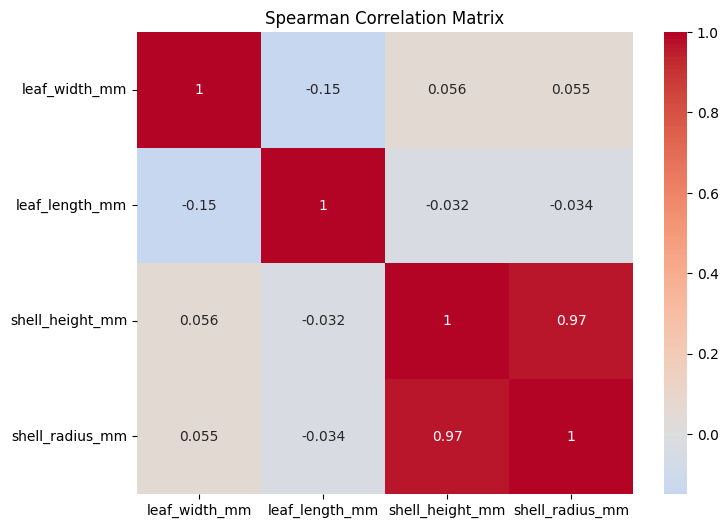

In [5]:
def data_report(df):
    print(f"DATA REPORT (rows={df.shape[0]}, columns={df.shape[1]})\n")

    # NaN report
    total_nans = df.isna().sum().sum()
    print(f"Total NaN values: {total_nans}")
    if total_nans > 0:
        print("NaNs per column:")
        print(df.isna().sum()[df.isna().sum() > 0])
    print()

    # Numeric columns stats
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    print("Numeric columns summary:")
    for col in numeric_cols:
        print(
            f"{col}: min={df[col].min():.2f}, "
            f"mean={df[col].mean():.2f}, "
            f"max={df[col].max():.2f}"
        )
    print()

    # Categorical columns
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns
    print("Categorical columns value counts:")
    for col in categorical_cols:
        print(f"\n{col}:")
        print(df[col].value_counts())

data_report(raw)

clean = raw.copy()

# 1. Drop rows with any NaNs
clean = clean.dropna()

# 2. Remove rows with invalid numeric values (negative or zero where impossible)
numeric_cols = clean.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    clean = clean[clean[col] >= 0]

print("Clean data shape:", clean.shape)



data_report(clean)



corr = clean.select_dtypes(include=[np.number]).corr(method="spearman")

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    center=0
)
plt.title("Spearman Correlation Matrix")
plt.show()



In [6]:
assert isinstance(raw, pd.DataFrame)
assert isinstance(clean, pd.DataFrame)
assert clean.isna().sum().sum() == 0
assert len(raw.columns) == len(clean.columns)
assert TO_PREDICT in raw.columns
assert TO_PREDICT in clean.columns

# 🔨 Task 2 (1 point): Data transformation and preparation for training

Next step is to prepare data for the model training. The DataFrame created during this task should be called `transformed`.

1. (0.4p) Standardize numeric columns:
   - using the `scikit-learn` package;
   - using just `numpy`;
   - Compare results and show that they are the same or similar enough. If there is any difference, notice how big it is.
2. (0.3p) Encode all categorical columns except snail genus using one-hot encoding from `pandas` or `scikit-learn`. Make sure that in the end, there are N-1 columns for a categorical column with N unique values. Make sure that old categorical columns are not left in the data.
3. (0.2p) Encode the snail genus as integer column using `pandas` or `numpy`. Make sure to create a dictionary `snail_classes` mapping snail genera and integers.
4. (0.1p) Create `X` and `y` from the whole data. The `X` should contain all columns except the snail genus column, and the `y` should contain only the snail genus column and be a `Series` object.

In [7]:
import numpy as np
from sklearn.preprocessing import StandardScaler

numeric_cols = clean.select_dtypes(include=[np.number]).columns
categorical_cols = clean.select_dtypes(exclude=[np.number]).columns.drop(TO_PREDICT)


scaler = StandardScaler()
scaled_sklearn = pd.DataFrame(
    scaler.fit_transform(clean[numeric_cols]),
    columns=numeric_cols,
    index=clean.index
)

scaled_numpy = (clean[numeric_cols] - clean[numeric_cols].mean()) / clean[numeric_cols].std()

diff = (scaled_sklearn - scaled_numpy).abs().max().max()
print(f"Max difference between sklearn and numpy scaling: {diff:.6f}")


encoded_cat = pd.get_dummies(
    clean[categorical_cols],
    drop_first=True
)


classes = sorted(clean[TO_PREDICT].unique())
snail_classes = {cls: idx for idx, cls in enumerate(classes)}

encoded_target = clean[TO_PREDICT].map(snail_classes).astype(int)


transformed = pd.concat(
    [scaled_sklearn, encoded_cat],
    axis=1
)

transformed[TO_PREDICT] = encoded_target


X = transformed.drop(columns=[TO_PREDICT])
y = transformed[TO_PREDICT]




Max difference between sklearn and numpy scaling: 0.000551


In [8]:
assert isinstance(transformed, pd.DataFrame)
assert transformed.isna().sum().sum() == 0
assert len(transformed.columns) > len(clean.columns)
assert TO_PREDICT in transformed.columns
assert transformed[TO_PREDICT].dtype == int
assert str not in transformed.dtypes  # CHECK IF WORKS
assert 2 in transformed[TO_PREDICT]
assert isinstance(X, pd.DataFrame)
assert len(X.columns) == len(transformed.columns) - 1
assert isinstance(y, pd.Series)
assert isinstance(snail_classes, dict)

# 🎓 Task 3 (1 point): Model training and evaluation

Write a function named `split_and_train_model` which uses the standard model training pipeline:
- It should take `X`, `y`, `random_seed`, and a function (type `Callable`) to create the model. It should also take an optional `max_iter` parameter with default value of 300.
- Inside, it should:
   - Correctly split `X` and `y` into `X_train`, `y_train`, `X_test`, `y_test`. You can use different names but the structure should remain the same. Use test size of 20%. Use `random_seed` to fix the random state of data splitting.
   - Create an instance of the chosen model (by calling the provided function), with its random seed fixed to `random_seed` parameter.
   - Use the model to fit `X_train` and `y_train`.
   - Use the fitted model to generate predictions from `X_test`.
   - Calculate the accuracy score by comparing `y_test` and obtained predictions. Print out the score (formatted using f-string).
   - Return the trained model.
   - In case of **any** exception, do not raise it, but print out the error message and return `None` instead.

As an usage example, use this function with the data prepared in Task 2 and `LogisticRegression` from `scikit-learn`.

In [9]:
from typing import Callable
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

def split_and_train_model(X, y, random_seed, model_fn: Callable, max_iter: int = 300):
    try:
        # 1) split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=0.2,
            random_state=random_seed,
            stratify=y  # helps when classes are imbalanced
        )

        # 2) create model (force random_state if supported)
        model = model_fn(random_state=random_seed, max_iter=max_iter)

        # 3) fit
        model.fit(X_train, y_train)

        # 4) predict + score
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        print(f"Accuracy: {acc:.4f}")

        # 5) return trained model
        return model

    except Exception as e:
        print(f"Error while training model: {e}")
        return None


logreg_model = split_and_train_model(
    X=X,
    y=y,
    random_seed=42,
    model_fn=lambda random_state, max_iter: LogisticRegression(
        random_state=random_state,
        max_iter=max_iter
    ),
    max_iter=300
)


Accuracy: 0.6923


In [10]:
# no asserts there!

# 🧩 Task 4 (2 points): Feature extraction - clustering

Someone from SNAILAB theorized that knowing the genus of the plant which the leaf belongs to should help predict the genus of the snail, as certain snails are attracted to certain plants. However, the dataset does not contain plant names, and either way, plant identification requires additional time and skill.

Instead, you can use unsupervised learning to cluster plant features and use this information as a new feature.

1. (0.1p) Create a new DataFrame `plants` containing only plant features from `transformed`. Here, you are allowed to write column names manually.
2. (0.9p) You will use several clustering methods: [Affinity Propagation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html), [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), [Spectral Clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html), and [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans). They allow to provide different clustering parameters. Create a list `cluster_setups` containing `tuple[str, Callable, dict]` items (setups), where `str` is a short model name just for printing purposes, `Callable` is the clustering function (which you will call), and `dict` is a dictionary of 1-2 parameters to provide to that function.
   - There should be several setups for each clustering method. Use `for` loops to create those setups automatically by going through lists of possible parameters. You are allowed to write the lists manually or use `np.linspace` and similar functions:
      - For Affinity Propagation, use 2-3 different `damping` values between 0.6 and 0.9;
      - For Spectral Clustering and KMeans, use 4-5 `n_clusters` values between 3 and 20.
      - For DBSCAN, use 4-5 `eps` values between 0.1 and 0.5, and 4-5 `min_samples` values between 5 and 40 (so each DBSCAN setup had two provided parameters instead of one).
3. (1.0p) For each setup in `cluster_setups`, fit a clustering model on `plants` data and get the preidcted labels for all plants. Save the labels into a dictionary `obtained_clusters` which should be of type `dict[str, list]`, The `str` keys should be some kind of automatically generated short model descriptions (e.g. use f-string and include used parameter values in it). The `list` values should be lists of predicted cluster labels.
   - You may want to use `tqdm` at this point, as some clustering methods are slower.

In [11]:
import numpy as np
import pandas as pd

from sklearn.cluster import AffinityPropagation, DBSCAN, SpectralClustering, KMeans

# 1) plants = only plant features from transformed
# We treat "leaf_*" as plant-related features.
plant_cols = [c for c in transformed.columns if c.startswith("leaf_")]
plants = transformed[plant_cols].copy()

# 2) Create cluster_setups: list[tuple[str, Callable, dict]]
def run_affinity(data, **params):
    model = AffinityPropagation(**params)
    labels = model.fit_predict(data)
    return labels

def run_dbscan(data, **params):
    model = DBSCAN(**params)
    labels = model.fit_predict(data)
    return labels

def run_spectral(data, **params):
    # affinity='nearest_neighbors' is usually more stable than default 'rbf'
    model = SpectralClustering(affinity="nearest_neighbors", **params)
    labels = model.fit_predict(data)
    return labels

def run_kmeans(data, **params):
    model = KMeans(**params)
    labels = model.fit_predict(data)
    return labels

cluster_setups = []

# Affinity Propagation: 2-3 damping values between 0.6 and 0.9
for damping in [0.6, 0.75, 0.9]:
    name = f"AffinityPropagation(damping={damping})"
    cluster_setups.append((name, run_affinity, {"damping": damping}))

# Spectral Clustering: 4-5 n_clusters values between 3 and 20
for n_clusters in [3, 5, 8, 12, 20]:
    name = f"SpectralClustering(n_clusters={n_clusters})"
    cluster_setups.append((name, run_spectral, {"n_clusters": n_clusters, "random_state": 42}))

# KMeans: 4-5 n_clusters values between 3 and 20
for n_clusters in [3, 5, 8, 12, 20]:
    name = f"KMeans(n_clusters={n_clusters})"
    cluster_setups.append((name, run_kmeans, {"n_clusters": n_clusters, "random_state": 42, "n_init": 10}))

# DBSCAN: 4-5 eps between 0.1 and 0.5 AND 4-5 min_samples between 5 and 40
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5]
min_samples_values = [5, 10, 20, 40]
for eps in eps_values:
    for min_samples in min_samples_values:
        name = f"DBSCAN(eps={eps},min_samples={min_samples})"
        cluster_setups.append((name, run_dbscan, {"eps": eps, "min_samples": min_samples}))

# 3) Fit each setup on plants and store labels
obtained_clusters = {}
plants_array = plants.to_numpy()

for name, fn, params in cluster_setups:
    labels = fn(plants_array, **params)
    obtained_clusters[name] = list(labels)

print(f"Plants shape: {plants.shape}")
print(f"Number of clustering setups: {len(cluster_setups)}")


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Plants shape: (2596, 4)
Number of clustering setups: 33


In [12]:
assert isinstance(plants, pd.DataFrame)
assert isinstance(cluster_setups, list)
assert isinstance(obtained_clusters, dict)
assert len(cluster_setups) == len(obtained_clusters)
assert len(cluster_setups) >= 26

# 👑 Task 5 (2 points): Using extracted features to improve the result

The only thing left now is to check which clustering setup produced a new feature (predicted plant clusters) which improves the Logistic Regression model trained in Task 3.

1. (1.0p) For each plant clustering result from Task 4, check if it improves the accuracy of logistic regression:
   - Create a new variable `XX` containing the `X` from Task 2 but joined with the new feature. If the shape of `X` was (M, N), then the shape of `XX` should be (M, N+1).
   - Using already written `split_and_train_model` function, create and fit a new logistic regression model on `XX` (`y` remains unchanged from Task 2). You may need to increase `max_iter` here. Don't forget to use the same random seed for all models.
2. (1.0p) Automatically find the feature which produced the best result from all trained Logistic Regression models. Print out its name and received accuracy score.


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

RANDOM_SEED = 42

# Baseline (no extra cluster feature) accuracy
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

baseline_model = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
baseline_model.fit(X_train, y_train)
baseline_preds = baseline_model.predict(X_test)
baseline_acc = accuracy_score(y_test, baseline_preds)

print(f"Baseline LogisticRegression accuracy (no clusters): {baseline_acc:.4f}")

best_name = None
best_acc = baseline_acc
best_model = baseline_model

results = []

for name, labels in obtained_clusters.items():
    # 1) make XX = X joined with 1 new feature column
    cluster_feature = pd.Series(labels, index=X.index, name="plant_cluster")

    XX = X.join(cluster_feature)

    # sanity check shape: (M, N+1)
    if XX.shape[1] != X.shape[1] + 1:
        print(f"Skipping {name}: shape mismatch {XX.shape} vs expected (M, N+1)")
        continue

    # 2) train/evaluate with same split
    X_train, X_test, y_train, y_test = train_test_split(
        XX, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
    )

    model = LogisticRegression(random_state=RANDOM_SEED, max_iter=2000)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)

    results.append((name, acc))

    # also run the required function (prints score + returns model)
    _ = split_and_train_model(
        XX, y, RANDOM_SEED,
        model_fn=lambda random_state, max_iter: LogisticRegression(random_state=random_state, max_iter=max_iter),
        max_iter=2000
    )

    if acc > best_acc:
        best_acc = acc
        best_name = name
        best_model = model

# 3) report best
results_sorted = sorted(results, key=lambda x: x[1], reverse=True)

print("\nTop 10 clustering features by accuracy:")
for n, a in results_sorted[:10]:
    print(f"{n}: {a:.4f}")

if best_name is None:
    print(f"\nNo clustering feature improved the baseline. Best remains baseline: {baseline_acc:.4f}")
else:
    print(f"\n Best clustering feature: {best_name}")
    print(f" Best accuracy: {best_acc:.4f} (baseline was {baseline_acc:.4f})")


Baseline LogisticRegression accuracy (no clusters): 0.6923
Accuracy: 0.7269
Accuracy: 0.7635
Accuracy: 0.7731
Accuracy: 0.7288
Accuracy: 0.7596
Accuracy: 0.7750
Accuracy: 0.7385
Accuracy: 0.7558
Accuracy: 0.7327
Accuracy: 0.7615
Accuracy: 0.7192
Accuracy: 0.8000
Accuracy: 0.7712
Accuracy: 0.7346
Accuracy: 0.7192
Accuracy: 0.7269
Accuracy: 0.6962
Accuracy: 0.7962
Accuracy: 0.7673
Accuracy: 0.7308
Accuracy: 0.7577
Accuracy: 0.7635
Accuracy: 0.7558
Accuracy: 0.7962
Accuracy: 0.7865
Accuracy: 0.7269
Accuracy: 0.7269
Accuracy: 0.7654
Accuracy: 0.7538
Accuracy: 0.7269
Accuracy: 0.7269
Accuracy: 0.7500
Accuracy: 0.7596

Top 10 clustering features by accuracy:
KMeans(n_clusters=12): 0.8000
DBSCAN(eps=0.2,min_samples=5): 0.7962
DBSCAN(eps=0.3,min_samples=20): 0.7962
DBSCAN(eps=0.3,min_samples=40): 0.7865
SpectralClustering(n_clusters=8): 0.7750
AffinityPropagation(damping=0.9): 0.7731
KMeans(n_clusters=20): 0.7712
DBSCAN(eps=0.2,min_samples=10): 0.7673
DBSCAN(eps=0.4,min_samples=20): 0.7654
Aff

In [14]:
# no asserts again!